In [23]:
import os
import numpy as np
import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


root = '/home/lin/Desktop/Coco/PennFudanPed'

class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root,"PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [24]:

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return(T.Compose(transforms))

In [25]:
root = '/home/lin/Desktop/Coco/PennFudanPed'


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = PennFudanDataset(root, get_transform(train=True))

In [26]:
for item in dataset:
    print(item)
    break

TypeError: __call__() takes 2 positional arguments but 3 were given

**My second attempt**: I tried this type of transformation

In [29]:
from torchvision import transforms


transform_train =transforms.Compose([transforms.RandomHorizontalFlip(1),transforms.ToTensor()])

dataset = PennFudanDataset(root, transform_train)

for item in dataset:
    print(item)
    
    break

TypeError: __call__() takes 2 positional arguments but 3 were given

**My third attepmt**: I load one image and its mask and I made the `target dict` in the class for this image and then I tried to apply transformations.

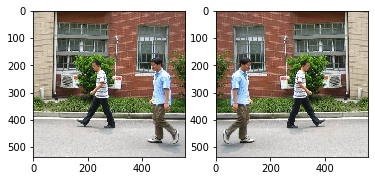

In [30]:

imgs = list(sorted(os.listdir(os.path.join(root,'PNGImages'))))


samimage_path = os.path.join(root,'PNGImages',imgs[0])    
samimage= Image.open(samimage_path)


plt.subplot(1,2,1)
plt.imshow(samimage)


type(samimage)


trn_img1 = transform_train(samimage)

plt.subplot(1,2,2)
plt.imshow(TF.to_pil_image(trn_img1))

mask before biniraziation 2 0
[0 1 2]
2
[159, 181, 301, 430]
[419, 170, 534, 485]
tensor([35358., 36225.])
tensor([0, 0])


TypeError: img should be PIL Image. Got <class 'dict'>

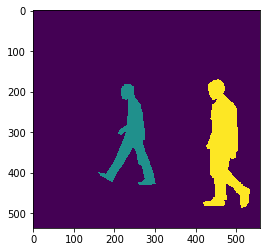

In [34]:
# Now we define mask and bounding box 

list_mask = sorted(list(os.listdir(os.path.join(root,'PedMasks'))))


mask0_path = os.path.join(root,'PedMasks',list_mask[0])


mask0 = Image.open(mask0_path)


plt.imshow(mask0)


#Converting mask to array
mask0= np.array(mask0)

type(mask0)

print('mask before biniraziation',np.max(mask0), np.min(mask0))

obj_ids = np.unique(mask0)
print(obj_ids)


#removing background
obj_ids = obj_ids[1:]



# now we split the color-encoded mask into a set of binary masks
mask_bn = mask0==obj_ids[:,None,None]

num_obj = len(obj_ids)

print(num_obj)

boxes = []

#Now we wnat to make boxes
for i in range(num_obj):
    
    pos =np.where(mask_bn[i])
    
    xmin= np.min(pos[1])
    xmax= np.max(pos[1])
    ymin= np.min(pos[0])
    ymax= np.max(pos[0])
    
    boxes.append([xmin,ymin,xmax,ymax])
    
    
print(boxes[0])


print(boxes[1])

# now wemake labels as follows
labels = torch.ones((num_obj,),dtype= torch.uint8)

# now we convert mask to tensor
mask_bn = torch.as_tensor(mask_bn,dtype = torch.uint8)


image_id = torch.tensor(1)



# first we convert boxes to  tensors 
boxes = torch.as_tensor(boxes,dtype= torch.float32)



area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
print(area)

iscrowd = torch.zeros((num_obj,),dtype = torch.int64)

print(iscrowd)

target = {}

target['boxes'] = boxes
target['area'] = area
target['iscrowd'] = iscrowd
target['image_id']= image_id
target['mask_bn'] = mask_bn
target['labels']= labels


target_tr = transform_train(target)